## 1.00 Initial Setup
Following tutorial from Langchain Opentutorial: https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial

Currently using Python 3.12
Includes LangSmith for collecting usage information
https://docs.smith.langchain.com/

In [ ]:
# Libraries needed
%pip install python-dotenv
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph
%pip install -U langchain langchain-openai

In [ ]:
# Step 1.01: Import required libraries
import os
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone
from langchain.docstore.document import Document
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA
from dotenv import load_dotenv

# Load API keys from .env file 
load_dotenv(override=True)

True

In [ ]:
# Step 1.02: Check API KEY
import os
print(f"[API KEY]\n{os.environ['LANGSMITH_API_KEY']}")

## 2.00 Initial Test with Open AI
Change the llm.invoke string to change query

### Step 2.01: Setup LLM object and ask a question

In [ ]:

from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Tell me a joke about graduate students.")

AIMessage(content='Why did the graduate student bring a ladder to the library?\n\nBecause they heard they needed to climb the academic ladder to succeed!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BCcFmfUahq7ifu3oEx2JRavWfFni3', 'finish_reason': 'stop', 'logprobs': None}, id='run-7d10d255-7be8-4a4d-aea2-0a8f32b0803d-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Step 2.02 Using other OpenAI models
examples: gpt-4o, gpt-4o-mini

In [10]:
from langchain_openai.chat_models import ChatOpenAI

# Create the ChatOpenAI object
llm = ChatOpenAI(
    temperature=1.5,  # Creativity (range: 0.0 ~ 2.0), larger value, more creative
    # max_tokens=100,  # Maximum number of tokens to generate
    model_name="gpt-4o-mini",  # Model name
)

question = "Tell me a joke about graduate students."

#print(f"[Answer]: {llm.invoke(question)}")

# Extract key components
response = llm.invoke(question)
content = response.content  # AI's response text
model_name = response.response_metadata["model_name"]
total_tokens = response.response_metadata["token_usage"]["total_tokens"]

# Print results
print(f"Response: {content}")
print(f"Model: {model_name}")
print(f"Total Tokens Used: {total_tokens}")

Response: Why don't graduate students play hide and seek?

Because good luck hiding when they have to stop and collect data!
Model: gpt-4o-mini-2024-07-18
Total Tokens Used: 38


### Step 2.03 Streaming Output

Responses are generated similar to regular ChatGPT interactions instead of all at once like the last cells.

In [4]:
# Create the ChatOpenAI object
llm = ChatOpenAI(
    temperature=1.5,  # Creativity (range: 0.0 ~ 2.0), larger value, more creative
    # max_tokens=100,  # Maximum number of tokens to generate
    model_name="gpt-4o-mini",  # Model name
)

answer = llm.stream(
    "Describe ideologies about science education held by teachers!"
)

# Streaming real-time output
for token in answer:
    print(token.content, end="", flush=True)

Teachers' ideologies about science education can vary widely based on their beliefs about effective teaching practices, the role of science in society, student learning processes, and overall educational philosophies. Here are some common ideologies that may shape teachers' approaches to science education:

1. **Constructivism**: Many educators believe in constructivist approaches, where students learn by actively constructing knowledge through hands-on activities, experiments, and inquiry-based learning. Teachers who hold this ideology often emphasize the importance of experiences and real-world applications in the science classroom, encouraging exploration, collaboration, and problem-solving.

2. **Direct Instruction**: Some educators might favor a more traditional or behaviorist form of teaching that relies on direct instruction, lectures, and standardized testing. In this ideology, the primary focus is on content delivery and the acquisition of specific scientific knowledge and fac

## 3.00 Multimodal LLM usage Text and Image processing using vision

### Step 3.01 Setup up LLM object

In [6]:
# Create the ChatOpenAI object
llm = ChatOpenAI(
    temperature=0.1,
    model_name="gpt-4o",
    streaming=True,  # Enable streaming for real-time output
)

### Step 3.02 Encoding Images into Base64 format for processing setup 
Images can be either in a local folder or on a website

In [7]:
import requests
import base64
import mimetypes
from IPython.display import display, HTML, Image


def encode_image(image_path_or_url):
    if image_path_or_url.startswith("http://") or image_path_or_url.startswith(
        "https://"
    ):
        # Download image from URL
        response = requests.get(image_path_or_url)
        if response.status_code == 200:
            image_content = response.content
        else:
            raise Exception(f"Failed to download image: {response.status_code}")
        # Guess MIME type based on URL
        mime_type, _ = mimetypes.guess_type(image_path_or_url)
        if mime_type is None:
            mime_type = (
                "application/octet-stream"  # Default MIME type for unknown files
            )
    else:
        # Read image from local file
        try:
            with open(image_path_or_url, "rb") as image_file:
                image_content = image_file.read()
            # Guess MIME type based on file extension
            mime_type, _ = mimetypes.guess_type(image_path_or_url)
            if mime_type is None:
                mime_type = (
                    "application/octet-stream"  # Default MIME type for unknown files
                )
        except FileNotFoundError:
            raise Exception(f"File not found: {image_path_or_url}")

    # Base64 encode the image
    return f"data:{mime_type};base64,{base64.b64encode(image_content).decode()}"

### Step 3.03 Create the System and User prompt message
Define a function to generate the messages required for the model. This includes:

- **System Prompt**: Defines the role and task for the AI.
- **User Prompt**: Provides the specific task instructions.
- **Encoded Image**: Includes the Base64 image data.


**System Prompt**
Defines the AI's identity, responsibilities, and behavior for the session:

* Sets the AI's context, ensuring consistent responses.
* Example: "You are a financial assistant specializing in interpreting tables."

**User Prompt**
Gives task-specific instructions to guide the AI:

* Specifies what the user expects the AI to do.
* Example: "Analyze this financial table and summarize the insights."

In [ ]:
SYSTEM_PROMPT = "You are an expert in curriculum design helpful."
USER_PROMPT = "What type of educational ideologies are represented in this image?"

# Function to create messages for the AI
def create_messages(encoded_image):
    system_prompt = SYSTEM_PROMPT
    user_prompt = USER_PROMPT
    return [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": user_prompt},
                {"type": "image_url", "image_url": {"url": encoded_image}},
            ],
        },
    ]

### Step 3.04 Model Interaction

Send message to model and stream output

In [17]:
def stream_response(llm, messages):
    response = llm.stream(messages)  # Stream AI response
    print("Streaming response:")
    for chunk in response:
        print(
            chunk.content, end="", flush=True
        )  # Print each response chunk in real time

#### Step 3.04a Image found on internet

In [22]:
IMAGE_URL = "https://activatelearning.com/wp-content/uploads/2024/10/OpenSciEd-Storylines-Structure-1024x505.jpg"

In [20]:
# Display the image
display(Image(url=IMAGE_URL))
encoded_image_url = encode_image(IMAGE_URL)

#  Create messages and stream responses
messages_url = create_messages(encoded_image_url)
stream_response(llm, messages_url)

Streaming response:
The image represents educational ideologies focused on inquiry-based and experiential learning. Here's how these ideologies are reflected:

1. **Inquiry-Based Learning**: 
   - The "Driving Question Board" and "Investigation Routine" emphasize developing questions and gathering evidence, which are key components of inquiry-based learning.

2. **Experiential Learning**: 
   - The "Anchoring Phenomenon Routine" involves sharing experiences, aligning with experiential learning where students learn through direct experience.

3. **Constructivism**:
   - The "Putting the Pieces Together Routine" and "Problematizing Routine" suggest a constructivist approach, where learners build understanding through collaboration and problem-solving.

4. **Reflective Learning**:
   - The "Navigation Routine" and "Questions Answered" stages involve reflection on learning progress and outcomes, which is crucial for deep learning.

These ideologies promote active engagement, critical think

#### Step 3.04b Image found in local folder

In [23]:
IMAGE_PATH = "images/Reported-confidence-in-ability-to-support-students-use-of-modeling-engagement-in_W640.jpg"


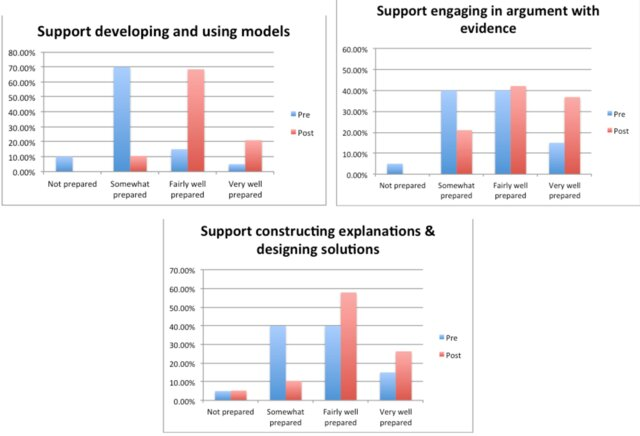

Streaming response:
The image represents educational ideologies focused on inquiry-based learning and constructivism. Here's how these ideologies are reflected:

1. **Inquiry-Based Learning**:
   - **Support Developing and Using Models**: Encourages students to explore and create models, fostering a hands-on, inquiry-driven approach.
   - **Support Engaging in Argument with Evidence**: Promotes critical thinking and reasoning, key components of inquiry-based learning.

2. **Constructivism**:
   - **Support Constructing Explanations & Designing Solutions**: Emphasizes students constructing their own understanding and knowledge through experiences and problem-solving.

These ideologies focus on active learning, critical thinking, and the application of knowledge, moving away from rote memorization towards deeper understanding and skill development.

In [24]:
# Encoding image

encoded_image_file = encode_image(IMAGE_PATH)
html_code = f'<img src="{encoded_image_file}" alt="Image" style="max-width: 100%; height: auto;">'
display(HTML(html_code))

# Create messages and stream responses
messages_file = create_messages(encoded_image_file)
stream_response(llm, messages_file)

## Step 4.00 Creating and working with Prompt Templates
A prompt template is built with a static prompt question attached to a variable that can be dynamic and based on ever chaning user input.

Example:  
What is the distance between {pointA} and {pointB}?
pointA = Pala Alto
pointB = Chicago

### Step 4.01 Define template and create 'PromptTemplat' object


In [25]:
from langchain_core.prompts import PromptTemplate

template = "What is the distance between {pointA} and {pointB}?"


prompt_template = PromptTemplate.from_template(template)
prompt_template 

PromptTemplate(input_variables=['pointA', 'pointB'], input_types={}, partial_variables={}, template='What is the distance between {pointA} and {pointB}?')

### Step 4.02 Generate the prompt


In [27]:
prompt = prompt_template.format(pointA="Palo Alto", pointB="Chicago")
prompt

'What is the distance between Palo Alto and Chicago?'

In [28]:
prompt = prompt_template.format(pointA="The Sun", pointB="Saturn")
prompt

'What is the distance between The Sun and Saturn?'